## packages

In [106]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## parameters

In [107]:
batch_size = 16
test_batch_size = 1000
epochs = 20
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 1000
cuda = torch.cuda.is_available()
weight_decay = 0.0005

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [108]:
cuda

True

## dataset

In [109]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## class names

In [110]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## The net

In [111]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5, 1, 0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        #图片维度(3,32,32)-->conv2d-->(6,28,28)-->pooling-->(6,14,14)
        #-->conv2d-->(16,10,10)-->pooling-->(16,5,5)
        
        self.linear1 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            nn.ReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU()
        )
        self.out = nn.Linear(84, 10)

        #initialization
        # nn.init.normal_(self.conv1[0].weight, 0, 0.01)
        # nn.init.normal_(self.conv2[0].weight, 0, 0.01)
        # nn.init.normal_(self.linear1[0].weight, 0, 0.01)
        # nn.init.normal_(self.linear2[0].weight, 0, 0.01)
        # nn.init.normal_(self.out.weight, 0, 0.01)

        #kaiming initialization
        nn.init.kaiming_normal_(self.conv1[0].weight)
        nn.init.kaiming_normal_(self.conv2[0].weight)
        nn.init.kaiming_normal_(self.linear1[0].weight)
        nn.init.kaiming_normal_(self.linear2[0].weight)
        nn.init.kaiming_normal_(self.out.weight)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.linear1(x)
        x = self.linear2(x)
        output = self.out(x)
        return output

In [112]:
model = Net()
if cuda:
    model.cuda()

## optimizer

In [118]:
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)

## train

In [119]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        epoch_loss = epoch_loss + loss.item()
    return epoch_loss/len(train_loader)

## test

In [120]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += nn.CrossEntropyLoss()(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (correct / len(test_loader.dataset)).item()

In [ ]:
loss_list = []
accuracy_list = []
for epoch in range(1,epochs + 1):
    loss_list.append(train(epoch))
    accuracy_list.append(test(epoch))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.884716
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.496964
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.987743
Train Epoch: 1 [48000/50000 (96%)]	Loss: 0.858764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  



Test set: Average loss: 1.0018, Accuracy: 6488/10000 (65%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.039489
Train Epoch: 2 [16000/50000 (32%)]	Loss: 0.827599
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.935916
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.339219

Test set: Average loss: 0.9696, Accuracy: 6568/10000 (66%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.029302
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.275278
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.983428
Train Epoch: 3 [48000/50000 (96%)]	Loss: 1.226604

Test set: Average loss: 0.9864, Accuracy: 6558/10000 (66%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.696207
Train Epoch: 4 [16000/50000 (32%)]	Loss: 0.832415
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.759496
Train Epoch: 4 [48000/50000 (96%)]	Loss: 0.842502

Test set: Average loss: 0.9414, Accuracy: 6738/10000 (67%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.509142
Train Epoch: 5 [16000/50000 (32%)]	Loss: 1.173352
Train Epoch: 5 [32000/50000 (64%)]	Loss: 2.153304
Train Epoch: 5 [48000/5000

In [72]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks'

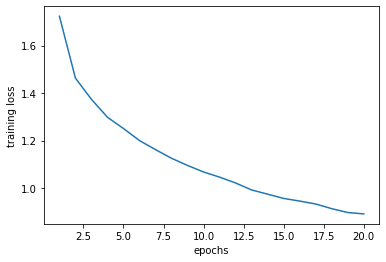

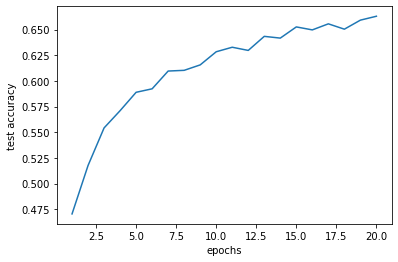

In [117]:
%matplotlib inline
plt.figure(1)
plt.plot(range(1,epochs + 1), loss_list)
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.savefig("loss_BN.pdf")

plt.figure(2)
plt.plot(range(1,epochs + 1), accuracy_list)
plt.xlabel("epochs")
plt.ylabel("test accuracy")
plt.savefig("accuracy_BN.pdf")

In [75]:
model.conv1[0].weight.shape


torch.Size([6, 3, 5, 5])

In [79]:
torch.min(model.conv1[0].weight)

tensor(-0.8072, device='cuda:0', grad_fn=<MinBackward1>)

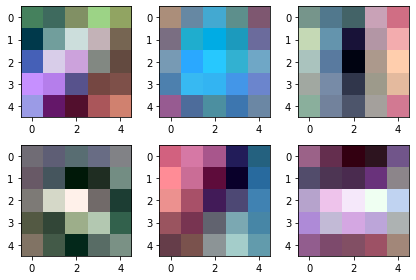

In [91]:
for i in range(6):
    plt.subplot(2,3,i+1)
    weight = model.conv1[0].weight[i].cpu().detach().numpy()
    weight = (weight - np.min(weight))/(np.max(weight)-np.min(weight))
    plt.imshow(weight.T)
    plt.tight_layout()
    plt.savefig("vis.pdf")